In [32]:
# Install seaborn if not already installed
import sys

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Experiment 1

In [34]:
import glob
import os

# 1. Dateien identifizieren (Ihre Logik)
jsonl_files = [f for f in glob.glob("results_vllm/*.jsonl") if 'n1' not in f and 'n5' not in f]

# 2. Daten laden & Mergen
dfs = []
for file in jsonl_files:
    # lines=True ist entscheidend für JSONL
    try:
        temp_df = pd.read_json(file, lines=True)
        # Optional: Modellname aus Dateiname extrahieren, falls nicht im JSON
        # temp_df['model_filename'] = os.path.basename(file) 
        dfs.append(temp_df)
    except ValueError as e:
        print(f"Fehler beim Lesen von {file}: {e}")

if not dfs:
    raise ValueError("Keine Dateien gefunden! Pfad prüfen.")

df = pd.concat(dfs, ignore_index=True)

In [35]:
df["model"].unique()

array(['Gemma-3-4B-vLLM', 'Qwen2.5-VL-7B-vLLM', 'Qwen2.5-VL-72B-AWQ-vLLM',
       'Ovis2.5-2B-vLLM', 'Gemma-3-12B-vLLM', 'Qwen3-VL-30B-Instruct',
       'Qwen2.5-VL-3B-vLLM', 'Ovis2.5-9B-vLLM', 'Qwen3-VL-2B-Instruct',
       'InternVL3-38B-vLLM', 'mistral-medium-2508', 'mistral-large-2512',
       'mistral-small-2506', 'InternVL3-8B-vLLM', 'InternVL3-14B-vLLM',
       'Idefics3-8B-Llama3-vLLM', 'Qwen3-VL-4B-Instruct',
       'Qwen3-VL-8B-Instruct', 'Gemma-3-27B-vLLM', 'Qwen2.5-VL-32B-vLLM'],
      dtype=object)

In [36]:
# Filter dataframe to only selected models
liste = ["Ovis2.5-9B-vLLM", "Qwen3-VL-8B-Instruct"]
# Use .isin() for vectorized membership test and make an explicit copy
if 'model' not in df.columns:
    raise ValueError("Column 'model' not found in DataFrame 'df'")

df_new = df[df["model"].isin(liste)].copy()
# optional: reset index
df_new.reset_index(drop=True, inplace=True)

In [37]:
df_new.to_csv("filtered_results.csv", index=False)

In [38]:
import pandas as pd

EXCLUDE_MODELS = {"Qwen3-VL-2B-Instruct"}

# ggf. anpassen, falls deine Modellspalte anders heißt
required = {"model", "math_category", "is_text_only", "difficulty", "is_correct"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Fehlende Spalten: {sorted(missing)}")

df = df[~df["model"].isin(EXCLUDE_MODELS)].copy()

# Accuracy je (model, category, modality, difficulty)
acc = (
    df.groupby(["model", "math_category", "is_text_only", "difficulty"])["is_correct"]
      .mean()
      .mul(100)
      .reset_index(name="acc")
)

# Pivot: Spalten = (is_text_only, difficulty)
pivot = acc.pivot_table(
    index=["model", "math_category"],
    columns=["is_text_only", "difficulty"],
    values="acc",
    aggfunc="first",
)

# ALL je Modalität (über alle Schwierigkeiten)
for mod in [True, False]:
    all_acc = (
        df[df["is_text_only"] == mod]
          .groupby(["model", "math_category"])["is_correct"]
          .mean()
          .mul(100)
    )
    pivot[(mod, "ALL")] = all_acc

# Spaltenreihenfolge
diff_order = ["A", "B", "C", "ALL"]
col_order = [(True, d) for d in diff_order] + [(False, d) for d in diff_order]
pivot = pivot.reindex(columns=col_order)

# schönere Spaltennamen (MultiIndex)
pivot.columns = pd.MultiIndex.from_tuples(
    [("Text-only" if m else "Visuell", d) for (m, d) in pivot.columns],
    names=["modalität", "difficulty"]
)

# optional: sortieren
pivot = pivot.sort_index()

# Ergebnis: DataFrame
pivot_df = pivot.round(1)
pivot_df  # Zum Einfügen in Excel/Sheets


ValueError: Fehlende Spalten: ['difficulty']

In [ ]:
#df.to_csv("merged_results.csv", index=False)

In [39]:
# 3. Preprocessing (Angepasst auf task_id)
# Logik: "1998_3und4_A1" -> split('_') -> ["1998", "3und4", "A1"] -> letztes Elem. "A1" -> erstes Zeichen "A"
df['difficulty'] = df['task_id'].apply(lambda x: str(x).split('_')[-1][0].upper())

# Score numerisch machen
df['score'] = df['is_correct'].astype(int)

# 4. Aggregation

# A) Gesamt Accuracy
acc_total = df.groupby('model')['score'].mean().to_frame(name='Acc')

# B) Modalität (Text vs. Visuell)
# False = Visuell notwendig, True = Text-only
acc_modal = df.groupby(['model', 'is_text_only'])['score'].mean().unstack()
acc_modal.columns = ['Visuell', 'Text-only'] 

# C) Schwierigkeit (Level A, B, C)
acc_diff = df.groupby(['model', 'difficulty'])['score'].mean().unstack()
acc_diff.columns = [f"Level {c}" for c in acc_diff.columns]

# D) Mathe-Kategorie
acc_cat = df.groupby(['model', 'math_category'])['score'].mean().unstack()

# 5. Zusammenfügen & Hierarchie
result = pd.concat([acc_total, acc_modal, acc_diff, acc_cat], axis=1)

# MultiIndex Spalten erstellen
multi_cols = []
for col in result.columns:
    if col == 'Acc':
        multi_cols.append(('Gesamt', 'Acc'))
    elif col in ['Text-only', 'Visuell']:
        multi_cols.append(('Modalität', col))
    elif 'Level' in col:
        multi_cols.append(('Schwierigkeit', col))
    else:
        multi_cols.append(('Kategorie', col))

result.columns = pd.MultiIndex.from_tuples(multi_cols)

# 6. Darstellung
result = result.sort_values(('Gesamt', 'Acc'), ascending=False)

In [40]:
result.to_csv("evaluation_summary_ex1.csv")

/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/214744063.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_score = text_scores[i]
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/214744063.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v_score = vis_scores[i]


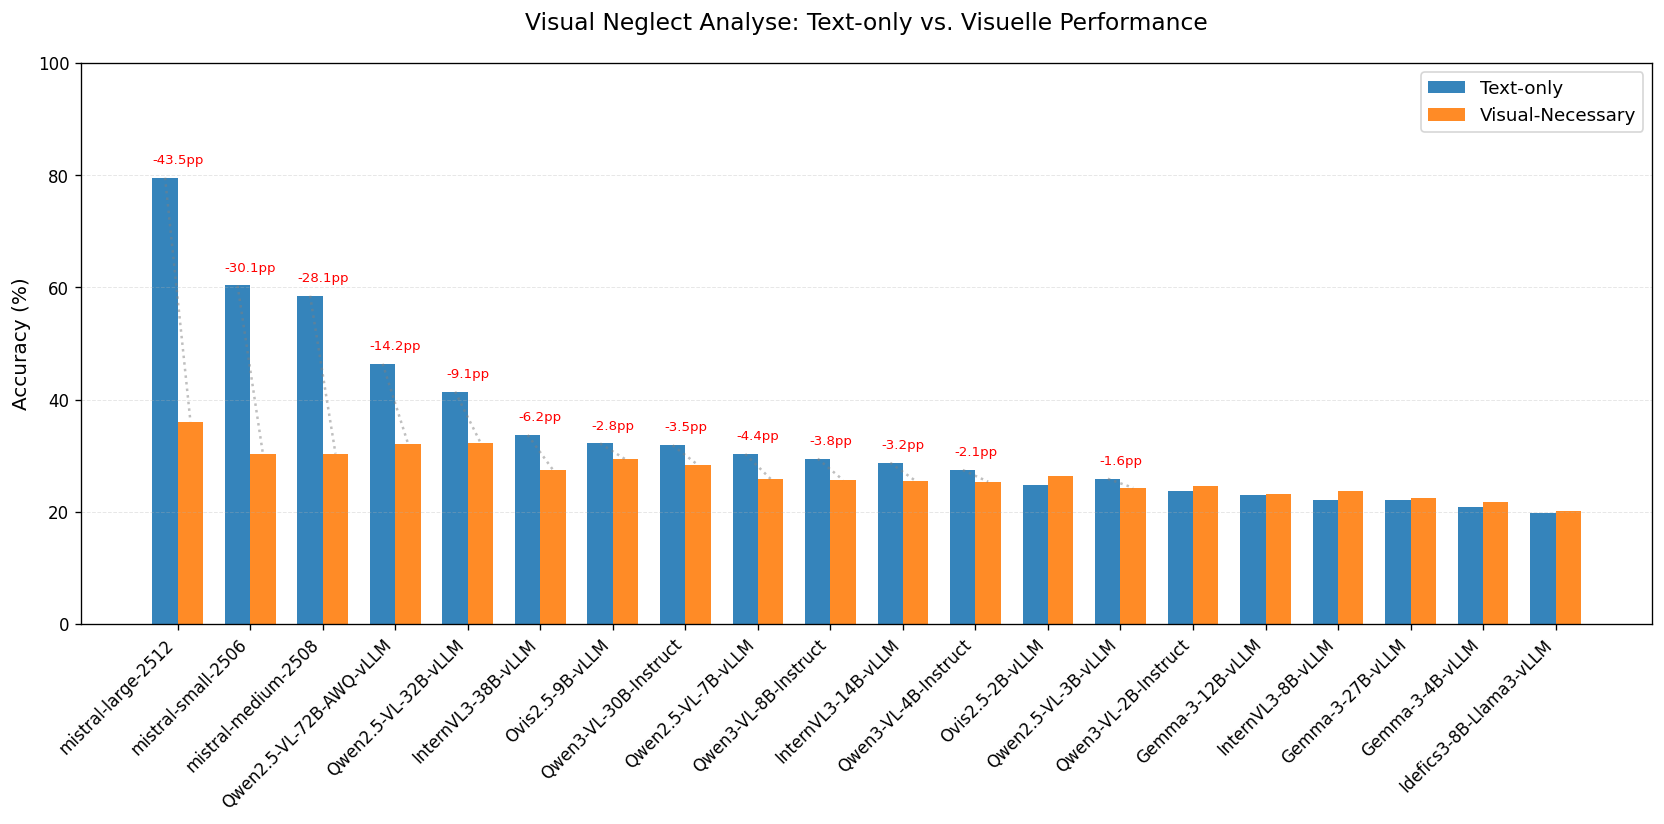

In [41]:

# Wir nutzen die Aggregation aus dem vorherigen Schritt
plot_data = result['Modalität'][['Text-only', 'Visuell']].copy()

# Optional: Sortieren nach dem "Visual Gap" (Text - Visuell), um den Effekt zu verdeutlichen
# plot_data['Gap'] = plot_data['Text-only'] - plot_data['Visuell']
# plot_data = plot_data.sort_values('Gap', ascending=False)
# Oder: Sortieren nach Modell-Familie (wie in der Tabelle) - wir lassen es hier wie in 'result' sortiert.

models = plot_data.index
text_scores = plot_data['Text-only'] * 100  # In Prozent
vis_scores = plot_data['Visuell'] * 100     # In Prozent

# 2. Plot-Setup
x = np.arange(len(models))  # Label Positionen
width = 0.35                # Breite der Balken

fig, ax = plt.subplots(figsize=(14, 7))

# Balken zeichnen
rects1 = ax.bar(x - width/2, text_scores, width, label='Text-only', color='#1f77b4', alpha=0.9)
rects2 = ax.bar(x + width/2, vis_scores, width, label='Visual-Necessary', color='#ff7f0e', alpha=0.9)

# 3. Styling & Labels
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Visual Neglect Analyse: Text-only vs. Visuelle Performance', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 4. "Insight"-Highlight: Gap Visualisierung (Optional)
# Zeichnet kleine Linien zwischen den Balken, um den Abstand zu zeigen
for i in range(len(models)):
    t_score = text_scores[i]
    v_score = vis_scores[i]
    
    # Nur zeichnen, wenn Text besser als Visuell (der Regelfall beim Visual Neglect)
    if t_score > v_score:
        # Linie zwischen den Balkenoberkanten
        ax.plot([x[i] - width/2, x[i] + width/2], [t_score, v_score], color='gray', linestyle=':', alpha=0.5)
        # Text für das Delta
        delta = t_score - v_score
        ax.text(x[i], max(t_score, v_score) + 2, f'-{delta:.1f}pp', 
                ha='center', va='bottom', fontsize=8, color='red', rotation=0)

plt.tight_layout()
plt.show()

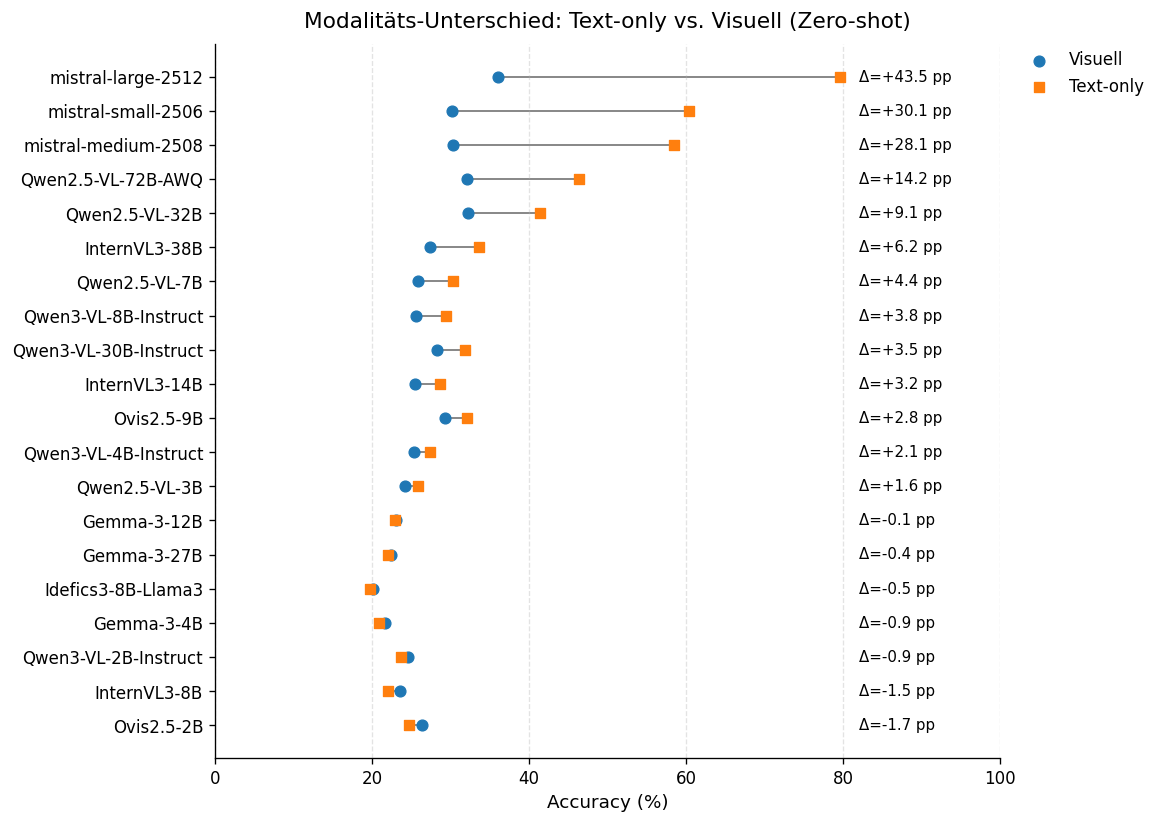

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def plot_modality_gap_dumbbell(plot_data, sort_by_gap=True, title=None, savepath=None):
    """
    plot_data: DataFrame, index = Modelle, Spalten = ['Text-only', 'Visuell']
              Werte entweder in [0,1] oder bereits in Prozent.
    """
    df = plot_data[['Text-only', 'Visuell']].copy()

    # robust: automatisch auf Prozent skalieren, falls Werte in [0,1]
    if df.max().max() <= 1.0:
        df = df * 100.0

    df['Gap_pp'] = df['Text-only'] - df['Visuell']  # Prozentpunkte

    if sort_by_gap:
        df = df.sort_values('Gap_pp', ascending=False)

    # ggf. Suffixe entfernen (wie bei dir)
    models = [m.replace('-vLLM', '') for m in df.index.to_list()]
    y = np.arange(len(models))

    text = df['Text-only'].to_numpy()
    vis  = df['Visuell'].to_numpy()
    gap  = df['Gap_pp'].to_numpy()

    fig, ax = plt.subplots(figsize=(10.5, max(4.5, 0.35 * len(models))))

    # Verbindungssegmente (Dumbbells) – EINHEITLICHE FARBE
    for i in range(len(models)):
        ax.plot([vis[i], text[i]], [y[i], y[i]],
                color="0.35", linewidth=1.2, alpha=0.7, zorder=1)


    # Punkte (Markerformen -> auch ohne Farbe unterscheidbar)
    ax.scatter(vis,  y, s=42, marker='o', linewidths=0.8, label='Visuell', zorder=3)
    ax.scatter(text, y, s=42, marker='s', linewidths=0.8, label='Text-only', zorder=3)

    # Δ-Annotation rechts neben den Segmenten
    x_max = float(max(df['Text-only'].max(), df['Visuell'].max()))
    pad = 2.5
    for i in range(len(models)):
        ax.text(x_max + pad, y[i], f"Δ={gap[i]:+,.1f} pp",
                va='center', ha='left', fontsize=9)

    # Achsen & Layout
    ax.set_yticks(y)
    ax.set_yticklabels(models, fontsize=10)
    ax.invert_yaxis()

    ax.set_xlabel('Accuracy (%)', fontsize=11)
    if title is None:
        title = 'Modalitäts-Unterschied: Text-only vs. Visuell (Zero-shot)'
    ax.set_title(title, fontsize=13, pad=10)

    # Skala + Grid
    ax.set_xlim(0, min(100, x_max + pad + 18))  # extra Platz rechts
    ax.grid(axis='x', linestyle='--', linewidth=0.8, alpha=0.35)

    # „Paper look“: Spines reduzieren
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Legende außerhalb (rechts oben) -> kein Overlap mit Δ
    ax.legend(
        frameon=False,
        fontsize=10,
        loc='upper left',
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.0
    )

    # Layout so, dass rechts Platz bleibt (Legende + Δ nicht abgeschnitten)
    fig.tight_layout()
    fig.subplots_adjust(right=0.80)

    if savepath:
        fig.savefig(savepath, bbox_inches='tight')  # z.B. "modality_gap.pdf"

    plt.show()


# Verwendung:
plot_data = result['Modalität'][['Text-only', 'Visuell']].copy()
plot_modality_gap_dumbbell(plot_data, sort_by_gap=True, savepath="modality_gap.pdf")


In [43]:
from math import pi
categories_df = result['Kategorie'][['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik', "unknown"]].copy()

In [44]:
categories_df

,Arithmetik,Algebra,Geometrie,Stochastik,unknown
model,,,,,
mistral-large-2512,0.777076,0.755481,0.436644,0.618887,0.461538
mistral-small-2506,0.659004,0.550091,0.348346,0.413043,0.348837
mistral-medium-2508,0.599639,0.554806,0.355613,0.424958,0.329670
Qwen2.5-VL-72B-AWQ-vLLM,0.451758,0.428331,0.350171,0.433390,0.340659
Qwen2.5-VL-32B-vLLM,0.399459,0.396290,0.342466,0.387858,0.428571
InternVL3-38B-vLLM,0.311993,0.317032,0.291096,0.350759,0.329670
Ovis2.5-9B-vLLM,0.308386,0.330523,0.294521,0.320405,0.362637
Qwen3-VL-30B-Instruct,0.305681,0.301855,0.304795,0.300169,0.351648
Qwen2.5-VL-7B-vLLM,0.286745,0.290051,0.269692,0.315346,0.252747


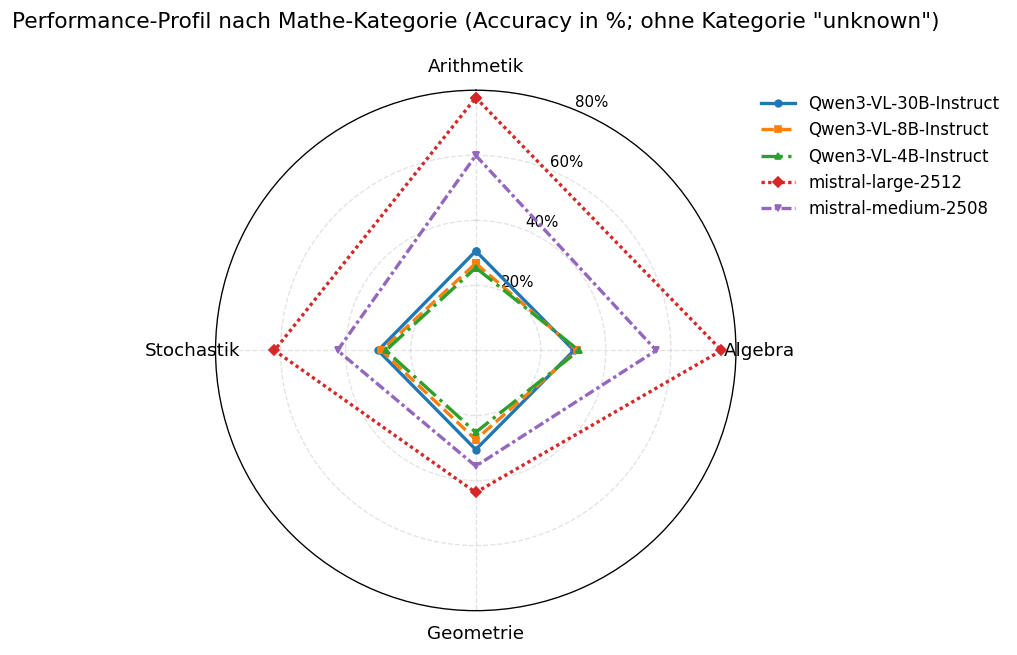

In [45]:
from math import pi
categories_df = result['Kategorie'][['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']].copy()

# robust: falls Werte in [0,1], auf Prozent skalieren
if categories_df.max().max() <= 1.0:
    categories_df = categories_df * 100.0

selection = [
    'Qwen3-VL-30B-Instruct', 'Qwen3-VL-8B-Instruct', 'Qwen3-VL-4B-Instruct',
    'mistral-large-2512', 'mistral-medium-2508',
]

plot_df = categories_df.loc[[m for m in selection if m in categories_df.index]]
# Attribute (Kategorien)
categories = list(plot_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7.5, 7.5), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)

# Dynamische r-Skala (auf Daten abgestimmt, "paper-like" ticks)
r_max = float(np.ceil(plot_df.to_numpy().max() / 10) * 10)  # z.B. auf 10er runden
ticks = np.linspace(0, r_max, 5)[1:]  # 4 ticks ohne 0
ax.set_yticks(ticks)
ax.set_yticklabels([f"{int(t)}%" for t in ticks], fontsize=9)
ax.set_ylim(0, r_max)

# dezentes Grid
ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.35)

linestyles = ['solid', 'dashed', 'dashdot', (0, (1, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v', 'P']

for i, (name, row) in enumerate(plot_df.iterrows()):
    vals = row.to_list()
    vals += vals[:1]
    ax.plot(
        angles, vals,
        linewidth=2.0,
        linestyle=linestyles[i % len(linestyles)],
        marker=markers[i % len(markers)],
        markersize=4,
        label=name
    )
    # Füllung sparsam oder weglassen (Paper-typisch eher weglassen)
    # ax.fill(angles, vals, alpha=0.06)

ax.legend(frameon=False, fontsize=10, loc='upper left', bbox_to_anchor=(1.02, 1.02))
ax.set_title("Performance-Profil nach Mathe-Kategorie (Accuracy in %; ohne Kategorie \"unknown\")", fontsize=13, pad=18)

plt.tight_layout()
plt.show()

In [46]:
df["model"].unique()

array(['Gemma-3-4B-vLLM', 'Qwen2.5-VL-7B-vLLM', 'Qwen2.5-VL-72B-AWQ-vLLM',
       'Ovis2.5-2B-vLLM', 'Gemma-3-12B-vLLM', 'Qwen3-VL-30B-Instruct',
       'Qwen2.5-VL-3B-vLLM', 'Ovis2.5-9B-vLLM', 'Qwen3-VL-2B-Instruct',
       'InternVL3-38B-vLLM', 'mistral-medium-2508', 'mistral-large-2512',
       'mistral-small-2506', 'InternVL3-8B-vLLM', 'InternVL3-14B-vLLM',
       'Idefics3-8B-Llama3-vLLM', 'Qwen3-VL-4B-Instruct',
       'Qwen3-VL-8B-Instruct', 'Gemma-3-27B-vLLM', 'Qwen2.5-VL-32B-vLLM'],
      dtype=object)

In [47]:
# df: Zeile = Aufgabe, mit Spalten: model, math_category, is_text_only, is_correct
cats = ['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']
sel = ['Qwen2.5-VL-72B-AWQ-vLLM', 'InternVL3-8B-vLLM', 'Qwen2.5-VL-32B-vLLM',
    'mistral-large-2512', 'Ovis2.5-9B-vLLM']

dff = df[df['math_category'].isin(cats) & df['model'].isin(sel)].copy()

def _pivot(modality_bool):
    tmp = dff[dff['is_text_only'] == modality_bool]
    out = (tmp.groupby(['model','math_category'])['is_correct'].mean()
              .unstack('math_category')
              .reindex(sel))
    return out * 100.0

plot_df_text = _pivot(True)[cats]
plot_df_vis  = _pivot(False)[cats]

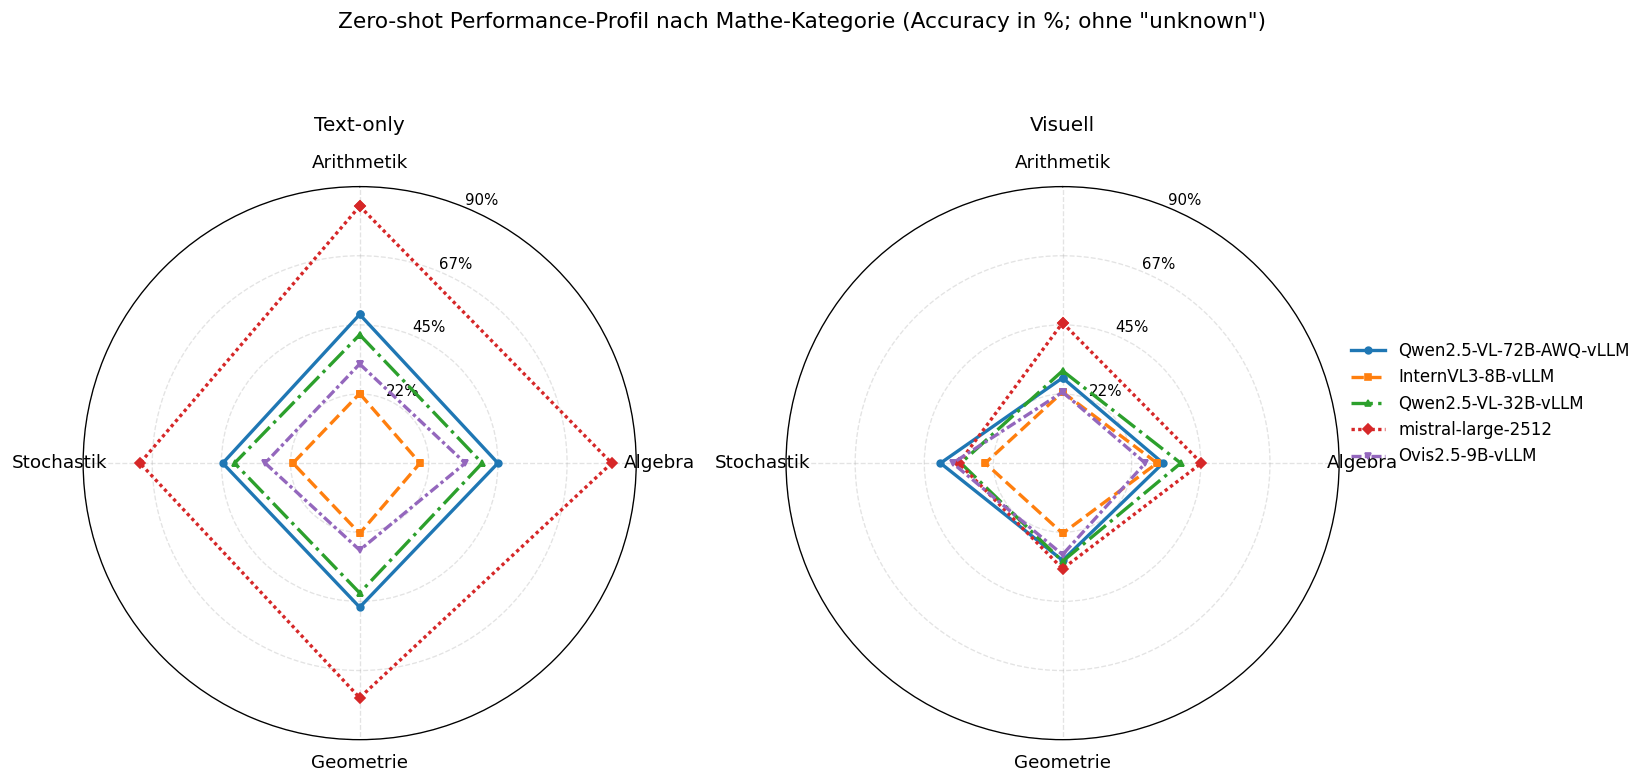

In [48]:
def _radar_panel(ax, plot_df, title, r_max, angles, categories,
                 linestyles, markers):
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)

    ticks = np.linspace(0, r_max, 5)[1:]  # 4 ticks ohne 0
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{int(t)}%" for t in ticks], fontsize=9)
    ax.set_ylim(0, r_max)

    ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.35)
    ax.set_title(title, fontsize=12, pad=14)

    handles = []
    labels = []
    for i, (name, row) in enumerate(plot_df.iterrows()):
        vals = row.to_list()
        vals += vals[:1]
        h = ax.plot(
            angles, vals,
            linewidth=2.0,
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=4,
            label=name
        )[0]
        handles.append(h)
        labels.append(name)
    return handles, labels


# -----------------------------
# Voraussetzung: zwei DF bauen
# plot_df_text: Accuracy% nach Kategorie nur Text-only
# plot_df_vis : Accuracy% nach Kategorie nur Visuell
# -----------------------------

# Kategorien (Spalten)
categories = ['Arithmetik', 'Algebra', 'Geometrie', 'Stochastik']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

linestyles = ['solid', 'dashed', 'dashdot', (0, (1, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v', 'P']

# Gemeinsame Skala (sehr wichtig)
global_max = max(plot_df_text.to_numpy().max(), plot_df_vis.to_numpy().max())
r_max = float(np.ceil(global_max / 10) * 10)

fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.8), subplot_kw=dict(polar=True))

h1, lab1 = _radar_panel(axes[0], plot_df_text, "Text-only", r_max, angles, categories, linestyles, markers)
h2, lab2 = _radar_panel(axes[1], plot_df_vis,  "Visuell",   r_max, angles, categories, linestyles, markers)

# Eine gemeinsame Legende (reduziert visuelles Rauschen)
fig.legend(h1, lab1, frameon=False, fontsize=10, loc='center right', bbox_to_anchor=(1.02, 0.5))

fig.suptitle('Zero-shot Performance-Profil nach Mathe-Kategorie (Accuracy in %; ohne "unknown")', fontsize=13, y=0.98)
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.show()


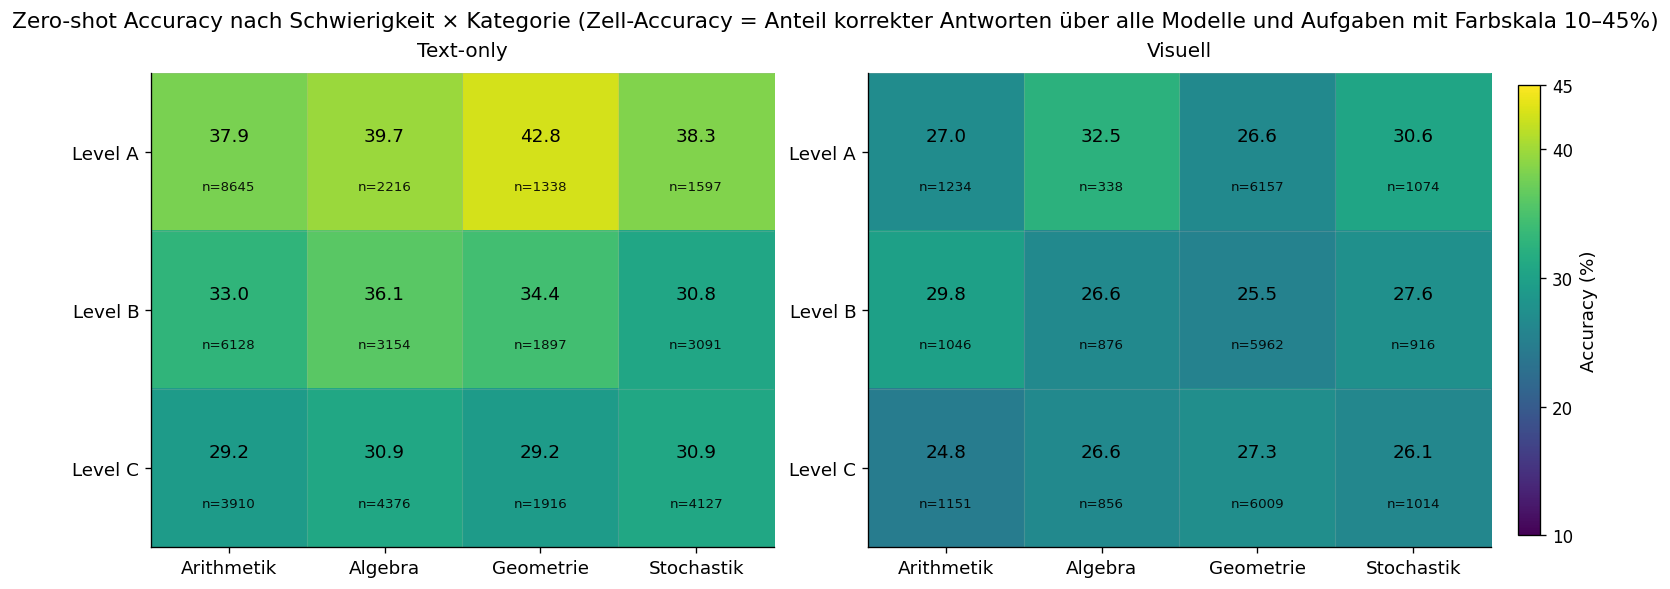

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CATS   = ["Arithmetik", "Algebra", "Geometrie", "Stochastik"]
LEVELS = ["A", "B", "C"]  # falls bei dir "Level A" etc. steht: hier anpassen

def variantA_cell_acc(df, cats=CATS, levels=LEVELS, text_only=None):
    """
    Variante A (pooled): Accuracy je (difficulty, category) über alle Modelle+Tasks.
    text_only: True (Text-only), False (Visuell), None (beides zusammen)
    Returns:
      acc: DataFrame (levels x cats) in Prozent
      n  : DataFrame (levels x cats) counts
    """
    d = df.copy()
    d = d[d["math_category"].isin(cats)]
    d = d[d["difficulty"].isin(levels)]

    if text_only is not None:
        d = d[d["is_text_only"] == bool(text_only)]

    g = d.groupby(["difficulty", "math_category"])["is_correct"]
    acc = (g.mean() * 100).unstack("math_category").reindex(index=levels, columns=cats)
    n   = g.size().unstack("math_category").reindex(index=levels, columns=cats)

    return acc, n


def plot_two_heatmaps(acc_left, n_left, acc_right, n_right,
                      title_left="Text-only", title_right="Visuell",
                      suptitle="Accuracy nach Schwierigkeit × Kategorie (Variante A, pooled)",
                      vmin=10.0, vmax=45.0,
                      savepath=None):
    """
    Zwei Heatmaps nebeneinander mit identischer (trunkierter) Skala, inkl. Zell-Annotation (Acc + n).
    vmin/vmax: hier bewusst 10–45, um Kontraste im relevanten Bereich sichtbar zu machen.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8), constrained_layout=True)

    def _panel(ax, acc, n, title):
        im = ax.imshow(acc.to_numpy(), vmin=vmin, vmax=vmax, aspect="auto")

        ax.set_title(title, fontsize=12, pad=10)

        ax.set_xticks(np.arange(acc.shape[1]))
        ax.set_xticklabels(acc.columns, fontsize=11)
        ax.set_yticks(np.arange(acc.shape[0]))
        ax.set_yticklabels([f"Level {x}" for x in acc.index], fontsize=11)

        # dezentes Zellgitter (paper-like)
        ax.set_xticks(np.arange(-0.5, acc.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, acc.shape[0], 1), minor=True)
        ax.grid(which="minor", linestyle="-", linewidth=0.7, alpha=0.25)
        ax.tick_params(which="minor", bottom=False, left=False)

        # Annotation: Accuracy + n; fehlende Zellen (NaN) überspringen
        for i in range(acc.shape[0]):
            for j in range(acc.shape[1]):
                val = acc.iat[i, j]
                cnt = n.iat[i, j]
                if pd.isna(val) or pd.isna(cnt):
                    continue

                ax.text(j, i - 0.10, f"{val:.1f}", ha="center", va="center", fontsize=11)
                ax.text(j, i + 0.22, f"n={int(cnt)}", ha="center", va="center", fontsize=8, alpha=0.9)

        # Spines reduzieren (cleaner Look)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        return im

    im0 = _panel(axes[0], acc_left,  n_left,  title_left)
    im1 = _panel(axes[1], acc_right, n_right, title_right)

    # gemeinsame Colorbar
    cbar = fig.colorbar(im1, ax=axes, shrink=0.95, pad=0.02)
    cbar.set_label("Accuracy (%)", fontsize=11)
    cbar.set_ticks([10, 20, 30, 40, 45])

    fig.suptitle(suptitle, fontsize=13)

    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    plt.show()


# -----------------------------
# Anwendung
# -----------------------------
# df: Raw-DF mit Spalten:
#   ['model','math_category','difficulty','is_text_only','is_correct', ...]
# Wichtig: 'unknown' vorher ggf. schon als math_category ausgeschlossen oder via CATS nicht enthalten.

acc_text, n_text = variantA_cell_acc(df, text_only=True)
acc_vis,  n_vis  = variantA_cell_acc(df, text_only=False)

plot_two_heatmaps(
    acc_text, n_text,
    acc_vis,  n_vis,
    title_left="Text-only",
    title_right="Visuell",
    suptitle='Zero-shot Accuracy nach Schwierigkeit × Kategorie (Zell-Accuracy = Anteil korrekter Antworten über alle Modelle und Aufgaben mit Farbskala 10–45%)',
    vmin=10.0, vmax=45.0,
    savepath="heatmap_difficulty_x_category_text_vs_vis_10_45.pdf"
)


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def wilson_ci(k, n, z=1.96):
    """Wilson score interval for a binomial proportion."""
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1.0 + (z**2)/n
    center = (phat + (z**2)/(2*n)) / denom
    half = (z * np.sqrt((phat*(1-phat))/n + (z**2)/(4*n**2))) / denom
    return (center - half, center + half)

def agg_acc_over_time(df, models, text_only=None, drop_unknown=True):
    """
    Returns DataFrame with columns: model, year, acc, n, lo, hi (acc/lo/hi in %).
    Variante A (pooled): pro Jahr werden alle Antworten der jeweiligen Filtermenge gepoolt.
    """
    d = df.copy()

    # grundlegende Filter
    d = d[d["model"].isin(models)]
    d = d[d["year"].notna()]

    if drop_unknown and "math_category" in d.columns:
        d = d[d["math_category"].ne("unknown")]

    if text_only is not None:
        d = d[d["is_text_only"] == bool(text_only)]

    # groupby
    g = d.groupby(["model", "year"])["is_correct"]
    out = g.agg(k="sum", n="size").reset_index()
    out["acc"] = (out["k"] / out["n"]) * 100.0

    # Wilson 95% CI
    ci = out.apply(lambda r: wilson_ci(int(r["k"]), int(r["n"])), axis=1)
    out["lo"] = [c[0] * 100.0 for c in ci]
    out["hi"] = [c[1] * 100.0 for c in ci]

    # sortieren
    out["year"] = out["year"].astype(int)
    out = out.sort_values(["model", "year"])

    return out


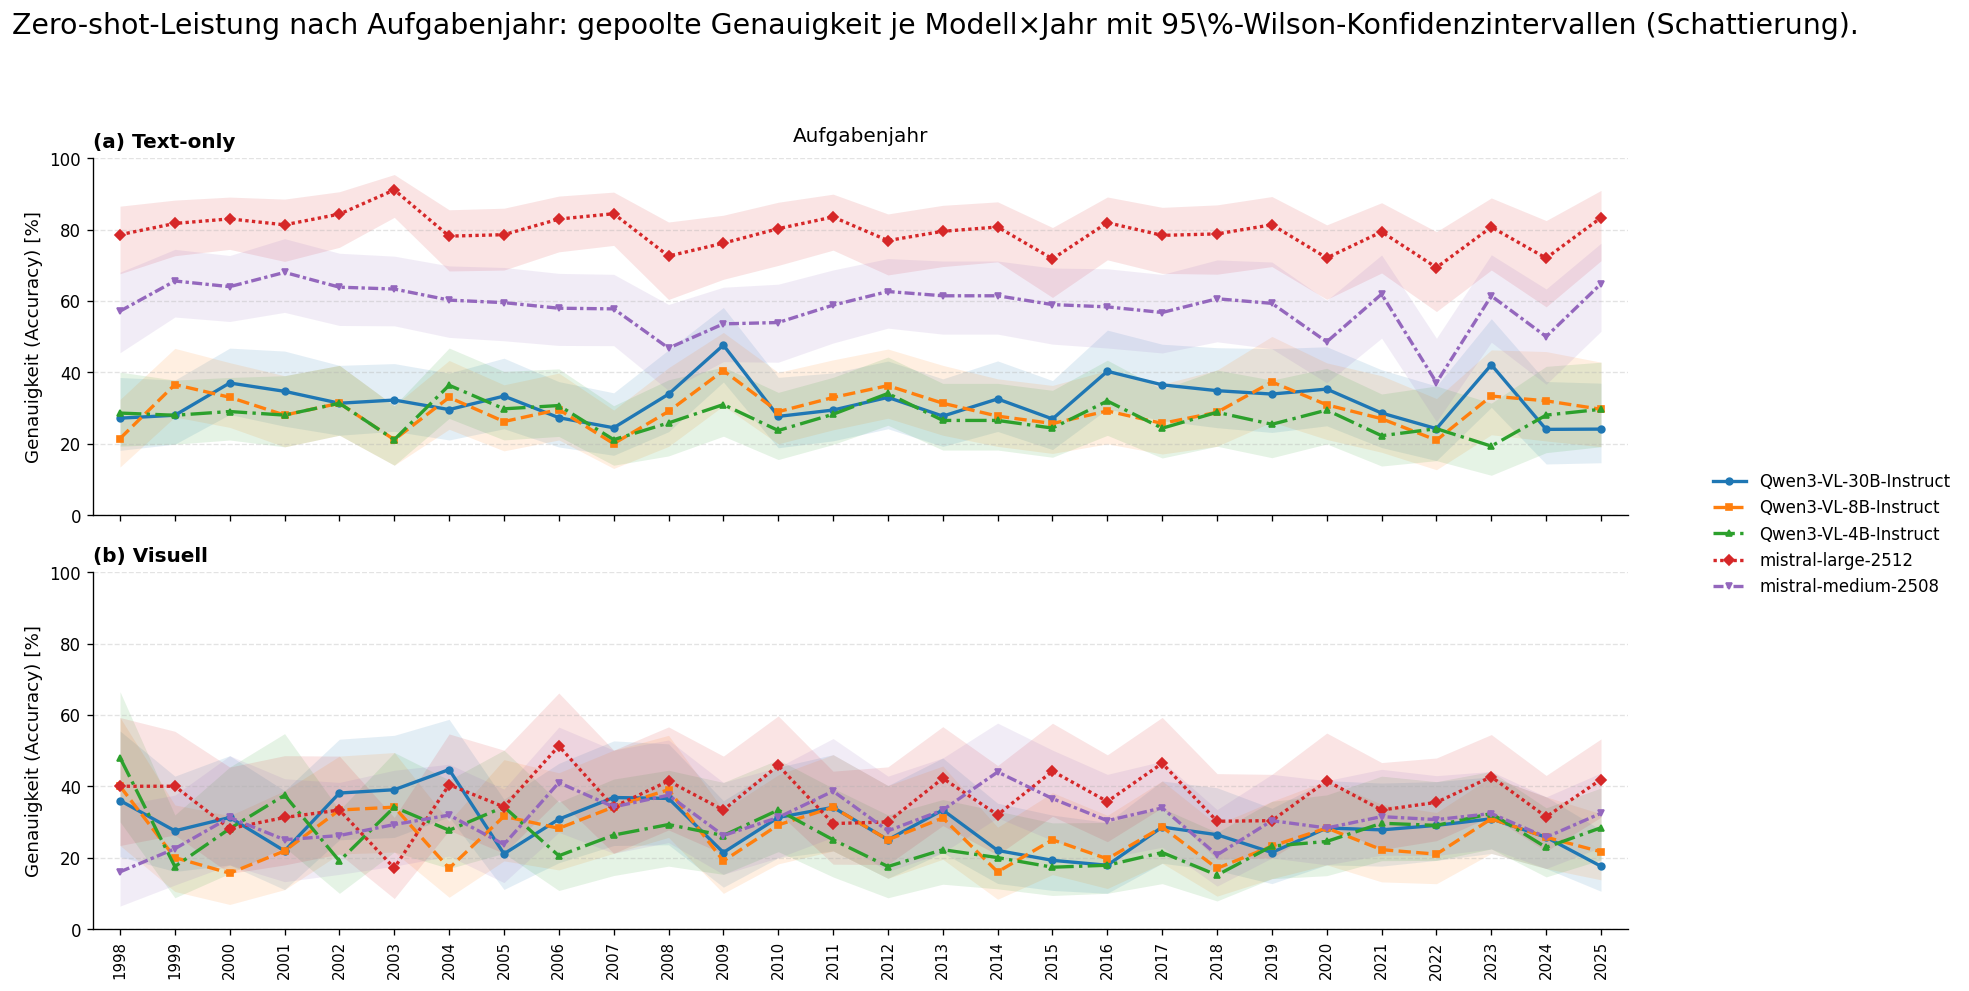

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_trend(ax, agg_df, models, years_all,
                    linestyles, markers, show_ci=True,
                    y_min=0, y_max=100, panel_label=None):
    ax.set_ylabel("Genauigkeit (Accuracy) [%]", fontsize=11)
    ax.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    handles, labels = [], []

    for i, m in enumerate(models):
        dm = agg_df[agg_df["model"] == m].copy()
        if dm.empty:
            continue

        # gemeinsame Jahresachse (konsistente x-Reichweite)
        dm = dm.set_index("year").reindex(years_all)

        x = np.array(years_all, dtype=int)
        y = dm["acc"].to_numpy(dtype=float)

        line = ax.plot(
            x, y,
            linewidth=2.0,
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=4,
            label=m
        )[0]

        if show_ci:
            lo = dm["lo"].to_numpy(dtype=float)
            hi = dm["hi"].to_numpy(dtype=float)
            ax.fill_between(x, lo, hi, alpha=0.12, color=line.get_color(), linewidth=0)

        handles.append(line)
        labels.append(m)

    # X-Achse: Jahre, vertikale Labels
    ax.set_xticks(years_all)
    ax.set_xlim(min(years_all) - 0.5, max(years_all) + 0.5)
    ax.tick_params(axis="x", labelrotation=90)
    for lbl in ax.get_xticklabels():
        lbl.set_ha("center")
        lbl.set_fontsize(9)

    ax.set_ylim(y_min, y_max)

    # Panel-Label (a)/(b)
    if panel_label is not None:
        ax.text(0.0, 1.02, panel_label,
                transform=ax.transAxes, ha="left", va="bottom",
                fontsize=12, fontweight="bold")

    return handles, labels


# -----------------------------
# Anwendung (2x1 Layout)
# -----------------------------
models = [
    'Qwen3-VL-30B-Instruct', 'Qwen3-VL-8B-Instruct', 'Qwen3-VL-4B-Instruct',
    'mistral-large-2512', 'mistral-medium-2508',
]

linestyles = ['solid', 'dashed', 'dashdot', (0, (1, 1)), (0, (3, 1, 1, 1))]
markers = ['o', 's', '^', 'D', 'v', 'P']

agg_text = agg_acc_over_time(df, models=models, text_only=True,  drop_unknown=True)
agg_vis  = agg_acc_over_time(df, models=models, text_only=False, drop_unknown=True)

years_all = sorted(set(agg_text["year"].dropna().astype(int).unique())
                   | set(agg_vis["year"].dropna().astype(int).unique()))

global_max = np.nanmax([agg_text["hi"].max(), agg_vis["hi"].max()])
y_max = float(np.ceil(global_max / 5) * 5)
y_min = 0.0

fig, axes = plt.subplots(2, 1, figsize=(16.5, 8.8), sharex=True, sharey=True)

h1, lab1 = plot_time_trend(
    axes[0], agg_text, models, years_all,
    linestyles=linestyles, markers=markers,
    show_ci=True, y_min=y_min, y_max=y_max,
    panel_label="(a) Text-only"
)

h2, lab2 = plot_time_trend(
    axes[1], agg_vis, models, years_all,
    linestyles=linestyles, markers=markers,
    show_ci=True, y_min=y_min, y_max=y_max,
    panel_label="(b) Visuell"
)

# kein X-Label unten
axes[1].set_xlabel("")

# X-Achsenlabel oben
axes[0].set_xlabel("Aufgabenjahr", fontsize=12, labelpad=10)
axes[0].xaxis.set_label_position("top")
axes[0].tick_params(axis="x", top=False)

# Legende außen rechts, vertikal zentriert
fig.legend(h1, lab1, frameon=False, fontsize=10,
           loc="center left", bbox_to_anchor=(0.885, 0.5))

# größere, akademische Beschreibung
fig.suptitle(
    "Zero-shot-Leistung nach Aufgabenjahr: gepoolte Genauigkeit je Modell×Jahr "
    "mit 95\\%-Wilson-Konfidenzintervallen (Schattierung).",
    fontsize=17, y=0.995
)

# Platz für Legende rechts + Suptitle
plt.tight_layout(rect=[0.03, 0.06, 0.86, 0.95])
plt.show()



In [52]:
df_new['difficulty'] = df_new['task_id'].apply(lambda x: str(x).split('_')[-1][0].upper())

In [53]:
df_new

,model,task_id,year,class,original_task_id,math_category,is_text_only,ground_truth,prediction,is_correct,format_valid,error_type,inference_time,input_tokens,raw_output,reasoning,error,difficulty
0,Ovis2.5-9B-vLLM,1998_3und4_A1,1998,3und4,A1,Arithmetik,True,D,E,False,True,NaN,11.7373,417.0,"{\n ""answer"": ""E""\n}",NaN,NaN,A
1,Ovis2.5-9B-vLLM,1998_3und4_A4,1998,3und4,A4,Algebra,True,B,E,False,True,NaN,0.2435,462.0,"{\n ""answer"": ""E""\n}",NaN,NaN,A
2,Ovis2.5-9B-vLLM,1998_3und4_B5,1998,3und4,B5,Algebra,True,C,E,False,True,NaN,0.2153,417.0,"{\n ""answer"": ""E""\n}",NaN,NaN,B
3,Ovis2.5-9B-vLLM,1998_3und4_C2,1998,3und4,C2,Stochastik,False,D,C,False,True,NaN,0.3404,1022.0,"{\n ""answer"": ""C""\n}",NaN,NaN,C
4,Ovis2.5-9B-vLLM,1998_3und4_C3,1998,3und4,C3,Arithmetik,True,E,C,False,True,NaN,0.2189,424.0,"{\n ""answer"": ""C""\n}",NaN,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,Qwen3-VL-8B-Instruct,2025_11bis13_C6,2025,11bis13,C6,Algebra,True,C,C,True,True,NaN,0.1112,469.0,"{\n ""answer"": ""C""\n}",NaN,NaN,C
7110,Qwen3-VL-8B-Instruct,2025_11bis13_C7,2025,11bis13,C7,Geometrie,False,E,B,False,True,NaN,0.1125,469.0,"{\n ""answer"": ""B""\n}",NaN,NaN,C
7111,Qwen3-VL-8B-Instruct,2025_11bis13_C8,2025,11bis13,C8,Geometrie,False,B,C,False,True,NaN,0.1067,423.0,"{\n ""answer"": ""C""\n}",NaN,NaN,C
7112,Qwen3-VL-8B-Instruct,2025_11bis13_C9,2025,11bis13,C9,Arithmetik,False,A,B,False,True,NaN,0.1078,469.0,"{\n ""answer"": ""B""\n}",NaN,NaN,C


/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  diff_data.pivot_table(index='math_category', columns='model', values='accuracy', aggfunc='mean')
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  diff_data.pivot_table(index='math_category', columns='model', values='accuracy', aggfunc='mean')
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify 

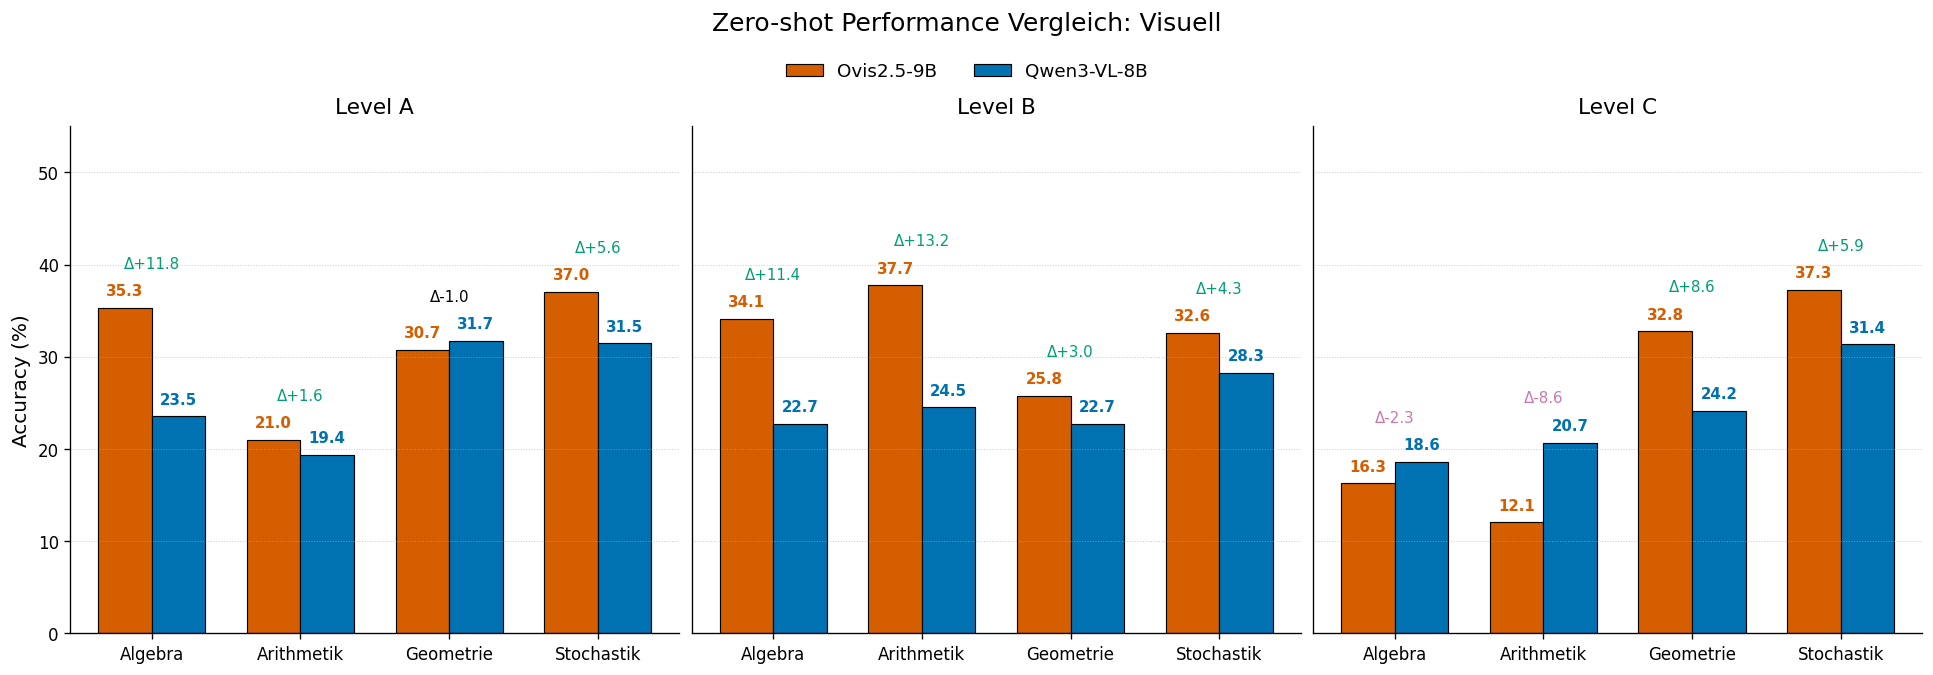

/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  diff_data.pivot_table(index='math_category', columns='model', values='accuracy', aggfunc='mean')
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  diff_data.pivot_table(index='math_category', columns='model', values='accuracy', aggfunc='mean')
/var/folders/ld/7gn78rl14ts7vgpp12q94y0w0000gn/T/ipykernel_14148/3533939182.py:74: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify 

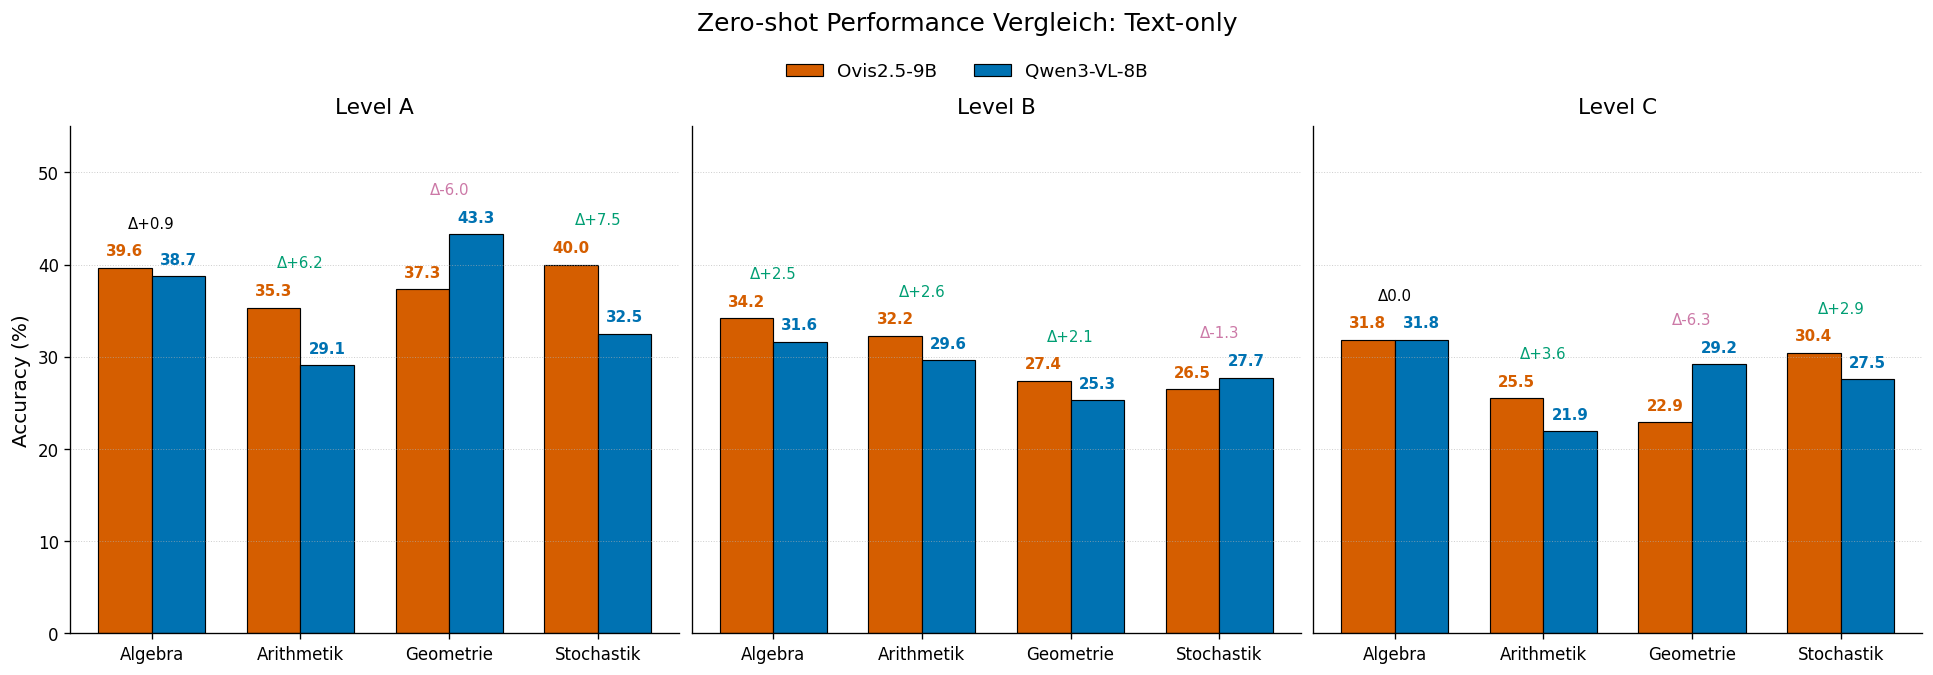

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_barchart_by_difficulty_matplotlib(df, is_text_only, save_path=None, ylim=(0, 55)):
    """
    3-spaltiges Balkendiagramm (A, B, C) für eine Modalität.
    Zeigt Ovis vs. Qwen inkl. Delta-Annotations. Reines matplotlib.
    """
    # -----------------------------
    # 1) Daten filtern & aggregieren
    # -----------------------------
    target_models = ['Ovis2.5-9B-vLLM', 'Qwen3-VL-8B-Instruct']
    target_cats   = ['Algebra', 'Arithmetik', 'Geometrie', 'Stochastik']
    difficulties  = ['A', 'B', 'C']

    subset = df[
        (df['model'].isin(target_models)) &
        (df['is_text_only'] == is_text_only) &
        (df['difficulty'].isin(difficulties)) &
        (df['math_category'].isin(target_cats))
    ].copy()

    # Mean accuracy in %
    agg = (
        subset.groupby(['difficulty', 'math_category', 'model'])['is_correct']
        .mean()
        .mul(100)
        .rename('accuracy')
        .reset_index()
    )

    # feste Reihenfolge erzwingen
    agg['math_category'] = pd.Categorical(agg['math_category'], categories=target_cats, ordered=True)
    agg['difficulty']    = pd.Categorical(agg['difficulty'], categories=difficulties, ordered=True)

    # -----------------------------------------
    # 2) "Akademisches" Layout / rcParams
    # -----------------------------------------
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "legend.fontsize": 11,
        "figure.dpi": 120
    })

    # Okabe–Ito (farbenblind-freundlich)
    colors = {
        'Ovis2.5-9B-vLLM': '#D55E00',      # Vermillion
        'Qwen3-VL-8B-Instruct': '#0072B2'  # Blue
    }
    hue_order = ['Ovis2.5-9B-vLLM', 'Qwen3-VL-8B-Instruct']

    modality_label = "Text-only" if is_text_only else "Visuell"

    # -----------------------------------------
    # 3) Plot
    # -----------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharey=True, constrained_layout=True)

    x = np.arange(len(target_cats))
    width = 0.36  # Balkenbreite

    for ax, diff in zip(axes, difficulties):
        diff_data = agg[agg['difficulty'] == diff]

        # Pivot: rows=category, cols=model, values=accuracy
        piv = (
            diff_data.pivot_table(index='math_category', columns='model', values='accuracy', aggfunc='mean')
            .reindex(target_cats)
        )

        ovis = piv.get(hue_order[0], pd.Series(index=target_cats, dtype=float)).to_numpy()
        qwen = piv.get(hue_order[1], pd.Series(index=target_cats, dtype=float)).to_numpy()

        # Balken zeichnen
        ax.bar(x - width/2, ovis, width=width, color=colors[hue_order[0]],
               edgecolor='black', linewidth=0.7, label='Ovis2.5-9B')
        ax.bar(x + width/2, qwen, width=width, color=colors[hue_order[1]],
               edgecolor='black', linewidth=0.7, label='Qwen3-VL-8B')

        # Styling
        ax.set_title(f"Level {diff}", pad=8)
        ax.set_xticks(x)
        ax.set_xticklabels(target_cats, rotation=0)
        ax.set_ylim(*ylim)

        ax.grid(axis='y', linestyle=':', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if diff == 'A':
            ax.set_ylabel("Accuracy (%)")
        else:
            ax.tick_params(axis='y', left=False)

        # -----------------------------------------
        # 4) Annotations: Werte + Delta
        # -----------------------------------------
        for i in range(len(target_cats)):
            val_ovis = ovis[i]
            val_qwen = qwen[i]

            # Falls fehlend (NaN), skip
            if np.isnan(val_ovis) and np.isnan(val_qwen):
                continue

            # Zahlen über Balken
            if not np.isnan(val_ovis):
                ax.text(i - width/2, val_ovis + 1.0, f"{val_ovis:.1f}",
                        ha='center', va='bottom', color=colors[hue_order[0]], fontweight='bold', fontsize=9)
            if not np.isnan(val_qwen):
                ax.text(i + width/2, val_qwen + 1.0, f"{val_qwen:.1f}",
                        ha='center', va='bottom', color=colors[hue_order[1]], fontweight='bold', fontsize=9)

            # Delta (Ovis - Qwen)
            if not np.isnan(val_ovis) and not np.isnan(val_qwen):
                delta = val_ovis - val_qwen
                sign = "+" if delta > 0 else ""
                # dezent: nur bei |Δ|>=1 farblich hervorheben
                if abs(delta) < 1:
                    delta_color = "black"
                else:
                    delta_color = "#009E73" if delta > 0 else "#CC79A7"  # Grün / Purpur (Okabe–Ito)

                y_anchor = max(val_ovis, val_qwen) + 4.0
                ax.text(i, y_anchor, f"Δ{sign}{delta:.1f}",
                        ha='center', va='bottom', fontsize=9, color=delta_color)

    # Gemeinsame Legende + Titel
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.08))
    fig.suptitle(f"Zero-shot Performance Vergleich: {modality_label}", y=1.14, fontsize=15)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


# Ausführung für beide Modalitäten
plot_barchart_by_difficulty_matplotlib(df_new, is_text_only=False, ylim=(0, 55))
plot_barchart_by_difficulty_matplotlib(df_new, is_text_only=True,  ylim=(0, 55))


## Experiment 2

In [55]:
# 1. Dateien identifizieren
# Stellen Sie sicher, dass der Pfad relativ zu Ihrem Skript korrekt ist.
# "results_vllm/*.jsonl" sucht in einem Unterordner 'results_vllm'.
file_pattern = "results_vllm/*.jsonl"
jsonl_files = glob.glob(file_pattern)

# Filtern nach 'n1' (falls gewünscht)
jsonl_files_n1 = [f for f in jsonl_files if 'n1' in f]

print(f"Gefundene Dateien im Pfad '{file_pattern}': {len(jsonl_files_n1)}")

dfs_n1 = []
failed_files = []

# 2. Daten laden
for file in jsonl_files_n1:
    try:
        # lines=True ist wichtig für JSONL Format
        temp_df = pd.read_json(file, lines=True)
        
        # WICHTIG: Modellname aus Dateinamen extrahieren, damit wir später gruppieren können
        # Wir nehmen den Dateinamen ohne Pfad und Endung als Modellname
        filename = os.path.basename(file)
        model_name = filename.replace('_results.jsonl', '') 
        temp_df['model'] = model_name
        
        dfs_n1.append(temp_df)
    except Exception as e:
        # Fehler protokollieren
        failed_files.append((file, str(e)))

# Bericht
if failed_files:
    print("\nACHTUNG: Folgende Dateien konnten nicht geladen werden:")
    for f, err in failed_files:
        print(f"- {f}: {err}")

if not dfs_n1:
    raise ValueError("Es konnten keine Dateien geladen werden. Bitte Pfad prüfen.")

# Zusammenfügen
df = pd.concat(dfs_n1, ignore_index=True)
print(f"\nErfolgreich geladen: {len(dfs_n1)} Dateien.")
print(f"Gesamtanzahl Zeilen: {len(df)}")

# ---------------------------------------------------------
# 3. Feature Engineering (Schwierigkeit & Analyse)
# ---------------------------------------------------------

# Schwierigkeit aus task_id extrahieren (z.B. "1998_3und4_A1" -> "A")
# Wir splitten am Unterstrich und nehmen vom letzten Teil den ersten Buchstaben
df['difficulty'] = df['task_id'].astype(str).apply(lambda x: x.split('_')[-1][0] if '_' in x else 'Unbekannt')

Gefundene Dateien im Pfad 'results_vllm/*.jsonl': 17

Erfolgreich geladen: 17 Dateien.
Gesamtanzahl Zeilen: 60469


In [62]:
df2 = df.copy()

In [57]:
# Berechnung der Overall Accuracy pro Modell
overall_accuracy = df.groupby('model')['is_correct'].mean().reset_index()

# Umbenennen für Klarheit
overall_accuracy.rename(columns={'is_correct': 'overall_accuracy'}, inplace=True)

# Sortieren (optional, aber hilfreich: beste Modelle oben)
overall_accuracy = overall_accuracy.sort_values(by='overall_accuracy', ascending=False)

# Anzeigen
display(overall_accuracy)

,model,overall_accuracy
11,Qwen2.5-VL-72B-Instruct-AWQ_CoT-Voting_n1,0.527692
5,InternVL3-38B-CoT-Voting_n1,0.487771
8,Ovis2.5-9B_CoT-Voting_n1,0.461063
4,InternVL3-14B-CoT-Voting_n1,0.456002
16,Qwen3-VL-8B-Instruct_CoT-Voting_n1,0.444476
1,Gemma-3-27B-vLLM_CoT-Voting_n1,0.434917
14,Qwen3-VL-30B-Instruct_CoT-Voting_n1,0.434355
15,Qwen3-VL-4B-Instruct_CoT-Voting_n1,0.409896
9,Qwen2.5-VL-32B-Instruct_CoT-Voting_n1,0.356480
0,Gemma-3-12B-vLLM_CoT-Voting_n1,0.342423


In [58]:
# 1. Gesamt-Accuracy berechnen
overall = df.groupby('model')['is_correct'].mean().mul(100)
overall.name = 'Gesamt_Acc'

# 2. Modalität (Text vs. Visuell) berechnen
# False = Visuell, True = Text-only
modality = df.pivot_table(index='model', columns='is_text_only', values='is_correct', aggfunc='mean').mul(100)
modality = modality.rename(columns={True: 'Text_only', False: 'Visuell'})

# Delta berechnen (Text - Visuell)
modality['Delta_TV'] = modality['Text_only'] - modality['Visuell']

# 3. Schwierigkeit (A, B, C) berechnen
difficulty = df.pivot_table(index='model', columns='difficulty', values='is_correct', aggfunc='mean').mul(100)
# Sicherstellen, dass die Spalten A, B, C existieren (falls ein Level in den Daten fehlt)
difficulty = difficulty.reindex(columns=['A', 'B', 'C'])
difficulty.columns = ['Level_A', 'Level_B', 'Level_C']

# 4. Alles zusammenfügen
final_table_df = pd.concat([overall, modality, difficulty], axis=1)

# 5. Runden auf 1 Nachkommastelle (wie in Ihrer Vorlage)
final_table_df = final_table_df.round(1)

# 6. CSV exportieren
final_table_df.to_csv('model_metrics_for_latex.csv')

# Vorschau anzeigen
print(final_table_df.head())

                                Gesamt_Acc  Visuell  Text_only  Delta_TV  \
model                                                                      
Gemma-3-12B-vLLM_CoT-Voting_n1        34.2     18.0       44.6      26.6   
Gemma-3-27B-vLLM_CoT-Voting_n1        43.5     21.1       57.7      36.5   
Gemma-3-4B-vLLM_CoT-Voting_n1         15.4     10.8       18.4       7.6   
Idefics3-8B-CoT-Voting_n1             17.9     18.1       17.7      -0.4   
InternVL3-14B-CoT-Voting_n1           45.6     27.7       57.0      29.3   

                                Level_A  Level_B  Level_C  
model                                                      
Gemma-3-12B-vLLM_CoT-Voting_n1     44.6     33.8     24.6  
Gemma-3-27B-vLLM_CoT-Voting_n1     52.6     45.2     32.9  
Gemma-3-4B-vLLM_CoT-Voting_n1      23.1     13.4      9.9  
Idefics3-8B-CoT-Voting_n1          18.1     18.2     17.3  
InternVL3-14B-CoT-Voting_n1        55.6     45.9     35.5  


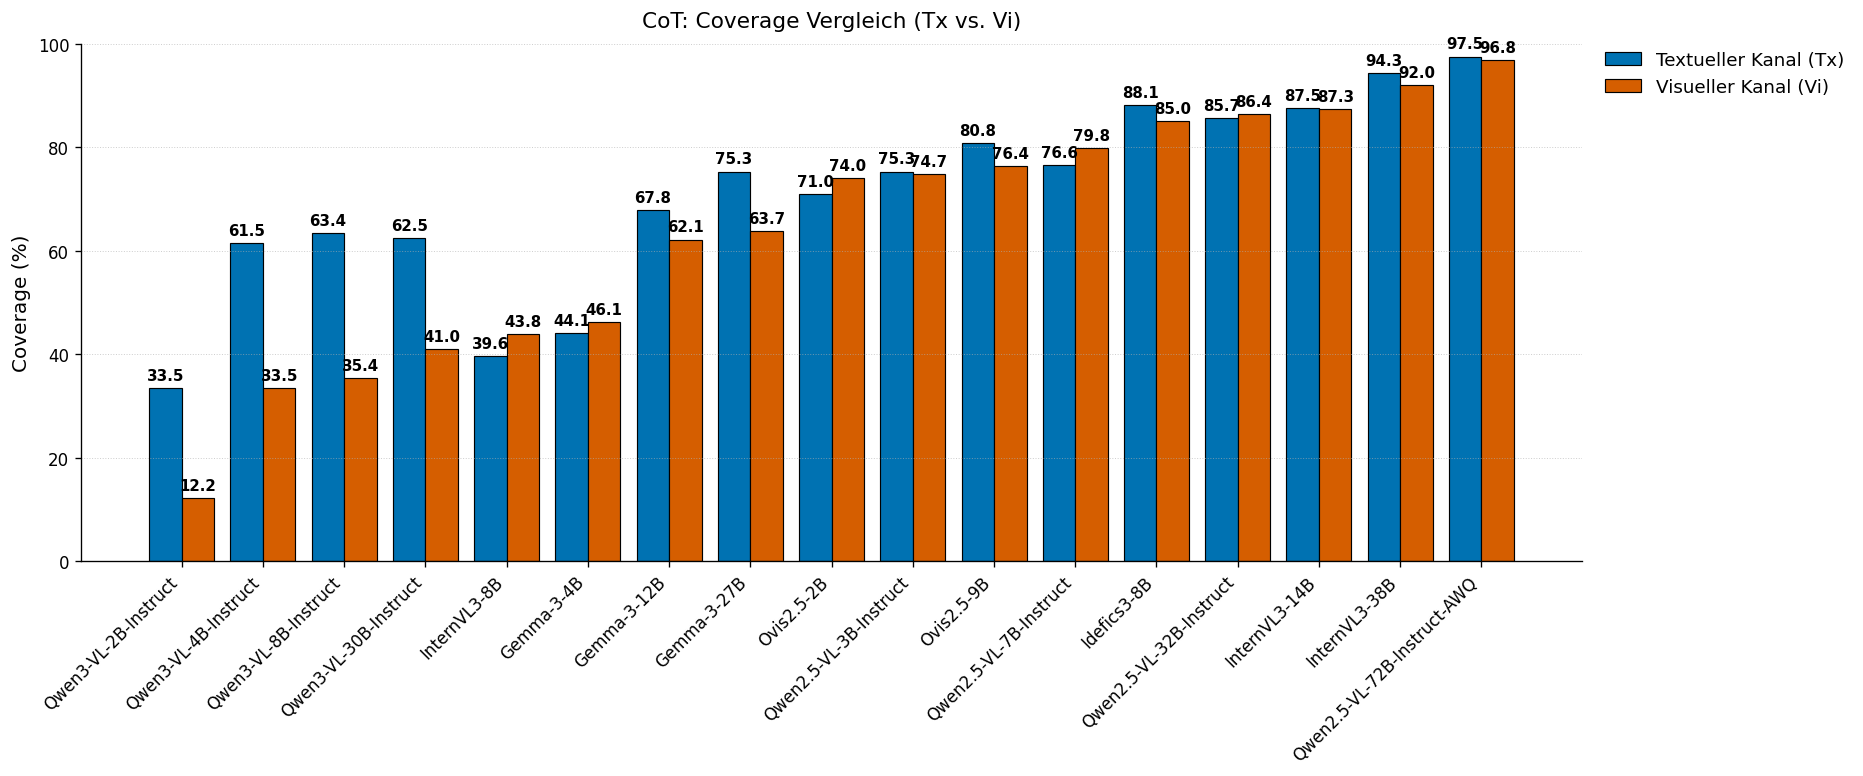

In [82]:
import re


def _clean_model_name(name: str) -> str:
    s = str(name)
    # wenn vLLM im Namen: ab vLLM abschneiden
    if re.search(r'vLLM', s, flags=re.IGNORECASE):
        s = re.sub(r'([_\-\s]?vLLM.*)$', '', s, flags=re.IGNORECASE)
        return s.strip()
    # sonst: ab CoT... abschneiden
    s = re.sub(r'([_\-\s]?CoT.*)$', '', s, flags=re.IGNORECASE)
    return s.strip()

def plot_grouped_coverage_cot_tx_vi_paper(
    df: pd.DataFrame,
    save_path: str | None = None,
    ylim: tuple = (0, 100),
    variant_col: str | None = None,
    variant_value: str | None = None,
    sort_by: str = "Vi",        # "Vi", "Tx", "gap", "name"
    ascending: bool = True,     # bei Vi: True = niedrigste Vi zuerst
    bar_width: float = 0.44,    # dicker als vorher (war 0.38)
    caption: bool = False       # Caption lieber in LaTeX
):
    """
    Gruppiertes Balkendiagramm: Coverage (CoT) nach Modalität pro Modell.
    - Textueller Kanal (Tx): is_text_only=True
    - Visueller Kanal (Vi): is_text_only=False
    Coverage = (# prediction != null) / (# Einträge) innerhalb (Modell, Modalität)
    Modellnamen werden bereinigt (vLLM*/CoT* entfernt).
    Legende steht rechts außerhalb der Achse.
    """

    # -----------------------------
    # 1) Daten vorbereiten
    # -----------------------------
    data = df.copy()

    # Optional: auf CoT filtern (falls df mehrere Settings enthält)
    if variant_col is not None and variant_value is not None and variant_col in data.columns:
        data = data[data[variant_col] == variant_value].copy()

    # Coverage strikt: prediction not null
    data["_has_pred"] = data["prediction"].notna().astype(int)
    data["_model_clean"] = data["model"].apply(_clean_model_name)

    agg = (
        data.groupby(["_model_clean", "is_text_only"])
            .agg(n_total=("prediction", "size"), n_pred=("_has_pred", "sum"))
            .reset_index()
    )
    agg["coverage"] = agg["n_pred"] / agg["n_total"] * 100.0
    agg["modality"] = np.where(agg["is_text_only"], "Tx", "Vi")

    piv = (
        agg.pivot_table(index="_model_clean", columns="modality", values="coverage", aggfunc="mean")
    )

    # -----------------------------
    # 2) Sortierung
    # -----------------------------
    if sort_by.lower() == "vi":
        sort_key = piv.get("Vi")
    elif sort_by.lower() == "tx":
        sort_key = piv.get("Tx")
    elif sort_by.lower() == "gap":
        sort_key = piv.get("Tx") - piv.get("Vi")
    else:  # "name"
        sort_key = piv.index.to_series()

    order = sort_key.sort_values(ascending=ascending).index.tolist()
    piv = piv.reindex(order)

    # -----------------------------
    # 3) Style (analog zu deinen Plots)
    # -----------------------------
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "legend.fontsize": 11,
        "figure.dpi": 120
    })

    color_tx = "#0072B2"  # Blau
    color_vi = "#D55E00"  # Orange (Okabe–Ito Vermillion)

    # -----------------------------
    # 4) Plot
    # -----------------------------
    fig, ax = plt.subplots(1, 1, figsize=(18, 5.6))

    x = np.arange(len(piv.index))
    width = bar_width

    tx = piv.get("Tx", pd.Series(index=piv.index, dtype=float)).to_numpy()
    vi = piv.get("Vi", pd.Series(index=piv.index, dtype=float)).to_numpy()

    bars_tx = ax.bar(
        x - width/2, tx, width=width,
        color=color_tx, edgecolor="black", linewidth=0.7,
        label="Textueller Kanal (Tx)"
    )
    bars_vi = ax.bar(
        x + width/2, vi, width=width,
        color=color_vi, edgecolor="black", linewidth=0.7,
        label="Visueller Kanal (Vi)"
    )

    ax.set_title("CoT: Coverage Vergleich (Tx vs. Vi)", pad=10)
    ax.set_ylabel("Coverage (%)")
    ax.set_ylim(*ylim)

    ax.grid(axis="y", linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xticks(x)
    ax.set_xticklabels(piv.index.tolist(), rotation=45, ha="right")

    # Legende rechts außerhalb + Platz schaffen
    ax.legend(
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.01, 1.0),
        borderaxespad=0.0
    )
    fig.subplots_adjust(right=0.82)  # ggf. 0.80–0.85

    # Prozentwerte über den Balken
    def _annotate(bars, values):
        for b, v in zip(bars, values):
            if np.isnan(v):
                continue
            ax.text(
                b.get_x() + b.get_width()/2,
                v + 1.0,
                f"{v:.1f}",
                ha="center", va="bottom",
                fontsize=9, fontweight="bold", color="black"
            )

    _annotate(bars_tx, tx)
    _annotate(bars_vi, vi)

    # Optional: Caption im Plot (standardmäßig aus)
    if caption:
        cap = (
            "Coverage im CoT-Setting, getrennt nach Text-only (Tx) und visuell notwendigen Aufgaben (Vi). "
            "Coverage = Anteil der Beispiele mit \\texttt{prediction} $\\neq$ null innerhalb der jeweiligen Modalität."
        )
        fig.subplots_adjust(bottom=0.26)
        fig.text(0.5, 0.01, cap, ha="center", va="bottom", fontsize=10, wrap=True)

    if save_path:
        fig.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()
    return piv, agg


# Beispiel:
piv_cov, agg_cov = plot_grouped_coverage_cot_tx_vi_paper(
     df2,
    sort_by="Vi",
     ascending=True,
    bar_width=0.40,
     caption=False
 )
